# ISSS621 - Data Science for Business
# Project
## Making Recommendations of H&M products based on Collaborative Filtering
#### The Model :
We used model-based Collaborative Filtering (matrix factorization) with Alternate Least Square (implicit package) to train the model. The metric we used is MAP@12 (12 mean average precision) as sugguested on the discussion page https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/305952
#### Limitation :
The analysis is limited by the memory and exectuion power of our personal machines which limits us to transaction data of the latest one months. This in turn limits the accuracy of our model as we do not utilise all the transactions of the customer over a longer period of time

In [1]:
import numpy as np
import pandas as pd
import implicit
from scipy.sparse import coo_matrix
from implicit.evaluation import mean_average_precision_at_k

In [2]:
transaction_train = pd.read_csv("transactions_train.csv",dtype={'article_id': str}, parse_dates=['t_dat'])

In [3]:
print(min(transaction_train['t_dat']),max(transaction_train['t_dat']))

2018-09-20 00:00:00 2020-09-22 00:00:00


In [4]:
df = transaction_train[transaction_train['t_dat']>='2020-09-01']
df.shape

(798269, 5)

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
ALL_USERS = df['customer_id'].unique().tolist()
ALL_ITEMS = df['article_id'].unique().tolist()

In [7]:
user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

In [8]:
user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

df['user_id'] = df['customer_id'].map(user_map)
df['item_id'] = df['article_id'].map(item_map)

In [9]:
# setup for matrix
row = df['user_id'].values
col = df['item_id'].values

In [10]:
data = np.ones(df.shape[0])
coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
coo_train

<189510x26252 sparse matrix of type '<class 'numpy.float64'>'
	with 798269 stored elements in COOrdinate format>

In [11]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=10, iterations=2)
model.fit(coo_train)

C:\Users\siyuf\anaconda3\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Wall time: 381 ms


In [12]:
def to_user_item_coo(df):
    # turn transaction df into a sparse matrix
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo

In [13]:
def split_data(df, validation_days=7):
    # split df into train and validation 
    validation_cut = df['t_dat'].max() - pd.Timedelta(days=validation_days)

    df_train = df[df['t_dat'] < validation_cut]
    df_val = df[df['t_dat'] >= validation_cut]
    return df_train, df_val

In [14]:
def get_val_matrices(df, validation_days=7):
    # split df to train and validation and turn both to sparse matrix
    df_train, df_val = split_data(df, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val
          }

In [15]:
def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    # train the ALS model - validate with MAP@12 (metric mentioned in Kaggle discussion)
    coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=show_progress, num_threads=4)
    
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [16]:
matrices = get_val_matrices(df)

In [17]:
matrices

{'coo_train': <189510x26252 sparse matrix of type '<class 'numpy.float64'>'
 	with 531905 stored elements in COOrdinate format>,
 'csr_train': <189510x26252 sparse matrix of type '<class 'numpy.float64'>'
 	with 473490 stored elements in Compressed Sparse Row format>,
 'csr_val': <189510x26252 sparse matrix of type '<class 'numpy.float64'>'
 	with 236622 stored elements in Compressed Sparse Row format>}

!Warning: running the following code will take 1 to 2 hours

In [18]:
%%time
# find best parameters based on map12
best_map12 = 0
for factors in [40, 50, 60, 100, 200, 500, 1000]:
    for iterations in [3, 12, 14, 15, 20]:
        for regularization in [0.01]:
            map12 = validate(matrices, factors, iterations, regularization, show_progress=False)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:  40 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00306
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 3, 'regularization': 0.01}
Factors:  40 - Iterations: 12 - Regularization: 0.010 ==> MAP@12: 0.00370
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 12, 'regularization': 0.01}
Factors:  40 - Iterations: 14 - Regularization: 0.010 ==> MAP@12: 0.00372
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 14, 'regularization': 0.01}
Factors:  40 - Iterations: 15 - Regularization: 0.010 ==> MAP@12: 0.00375
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 15, 'regularization': 0.01}
Factors:  40 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.00370
Factors:  50 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00285
Factors:  50 - Iterations: 12 - Regularization: 0.010 ==> MAP@12: 0.00379
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 12, 'regularization': 0.01}
Factors:  50 - Iterations: 14 - Regularization: 

##### Training the model with best parameters

In [19]:
best_params

{'factors': 100, 'iterations': 20, 'regularization': 0.01}

In [20]:
# training on the full dataset
coo_train = to_user_item_coo(df)
csr_train = coo_train.tocsr()

In [21]:
def train(coo_train, factors, iterations, regularization, show_progress=True):
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    return model

In [22]:
model = train(coo_train, **best_params)

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
def predict(model, csr_train):
    preds = []
    batch_size = 2000
    user_idx = np.arange(len(ALL_USERS))
    
    for startidx in range(0, len(user_idx), batch_size):
        batch = user_idx[startidx : startidx + batch_size]
        # let's recommend 6 items excluding already purchased items
        ids, scores = model.recommend(batch, csr_train[batch], N=6, filter_already_liked_items=True)
        
        for i, userid in enumerate(batch):
            customer_id = user_ids[userid]
            user_items = ids[i]
            article_ids = [item_ids[item_id] for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])
#     df_preds.to_csv(prediction.csv, index=False)
    return df_preds

In [24]:
df_preds = predict(model, csr_train)

In [25]:
df_preds.shape

(189510, 2)

In [26]:
df_preds.head()

,customer_id,prediction
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0865929007 0865929014 0903773001 0902388001 08...
1,0005ed68483efa39644c45185550a82dd09acb07622acb...,0863646001 0863646005 0863646002 0863646003 08...
2,0008f66f5804877333ab9942c880b4a222f5b1a9f6ce27...,0865929003 0797988002 0915529005 0865926002 08...
3,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,0562245046 0762846026 0827968001 0456163086 08...
4,0016640d72ad1bcfe8dc30d8be1da4426d172fc2d88189...,0896152001 0902419001 0896152003 0918516001 09...


visualise the results with images

In [27]:
def plot_purchase_history():
    fig = plt.figure(figsize=(20, 10))
    for item, i in zip(prev_items, range(1, len(prev_items)+1)):
        item = str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, len(prev_items), i)
        plt.imshow(image)

In [28]:
def plot_recommendation():
    #print(rcmnds)
    fig = plt.figure(figsize=(20, 10))
    for item, i in zip(rcmnds_img, range(1, 7)):
        item = str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, 6, i)
        plt.imshow(image)

In [29]:
path = "C:/Users/siyuf/Documents/H&M"

In [30]:
groupby_customer = df.groupby('customer_id')

In [31]:
# just a random customer index to see the results
import matplotlib.pyplot as plt
cus = 0
prev_items = groupby_customer.get_group(df_preds.iloc[cus,0])['article_id']
rcmnds_img = df_preds.iloc[cus,1].split()

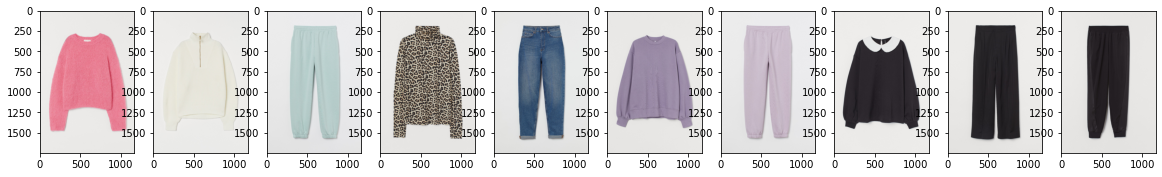

In [32]:
plot_purchase_history()

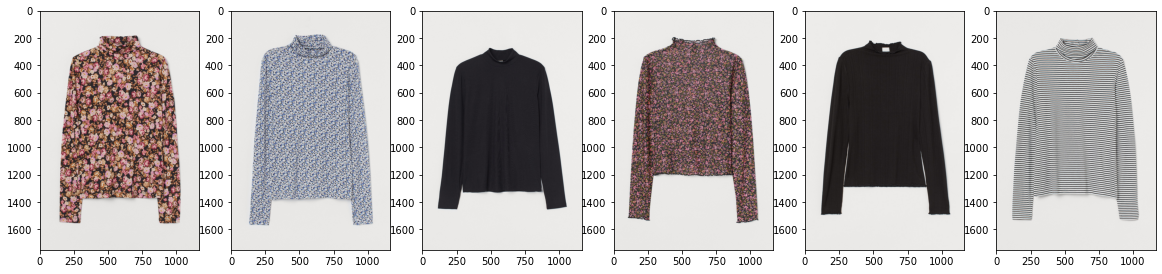

In [33]:
plot_recommendation()

In [34]:
cus = 2021
prev_items = groupby_customer.get_group(df_preds.iloc[cus,0])['article_id']
rcmnds_img = df_preds.iloc[cus,1].split()

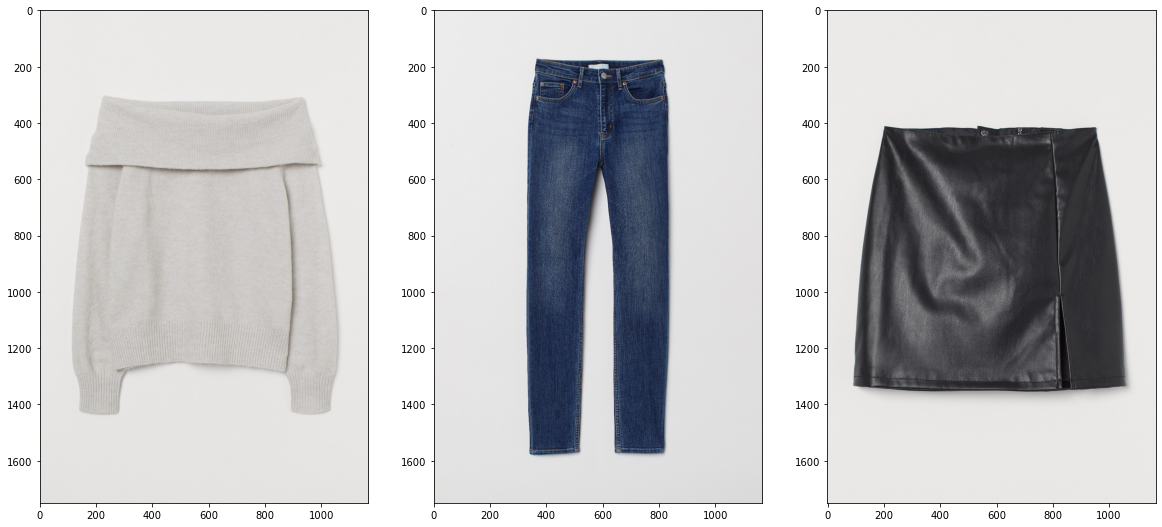

In [35]:
plot_purchase_history()

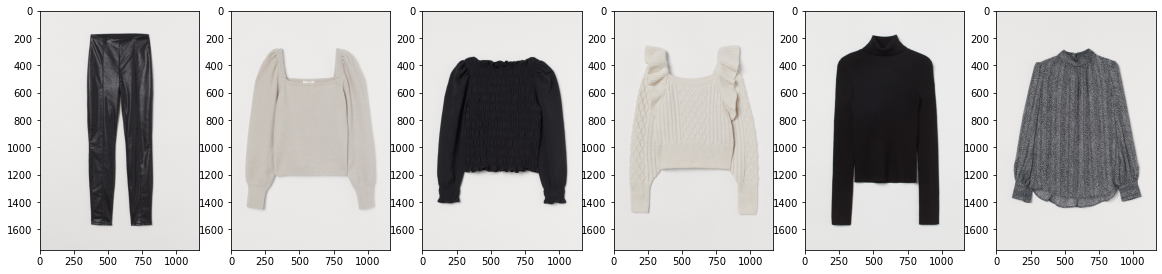

In [36]:
plot_recommendation()

In [37]:
cus = 4034
prev_items = groupby_customer.get_group(df_preds.iloc[cus,0])['article_id']
rcmnds_img = df_preds.iloc[cus,1].split()

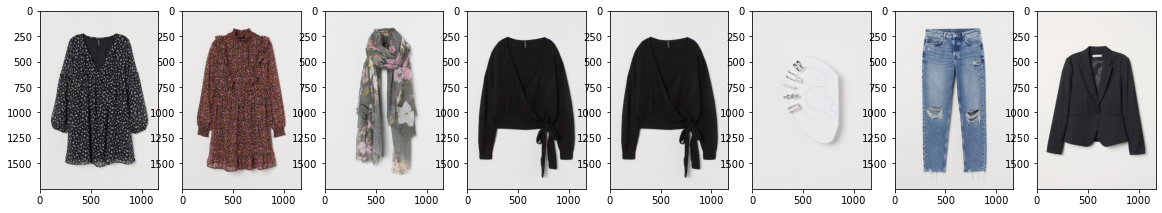

In [38]:
plot_purchase_history()

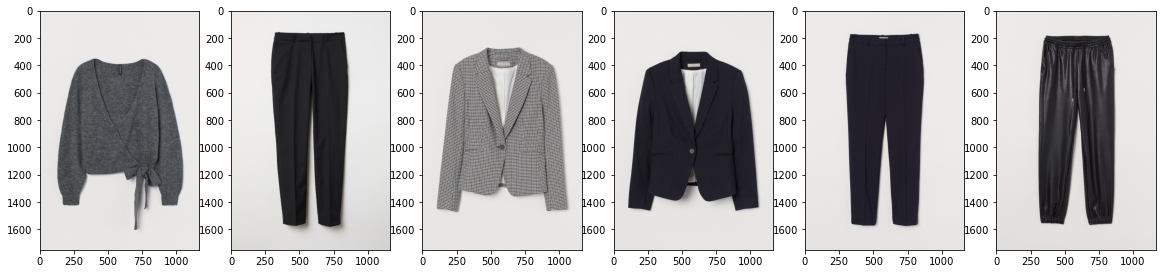

In [39]:
plot_recommendation()

In [40]:
cus = 5273
prev_items = groupby_customer.get_group(df_preds.iloc[cus,0])['article_id']
rcmnds_img = df_preds.iloc[cus,1].split()

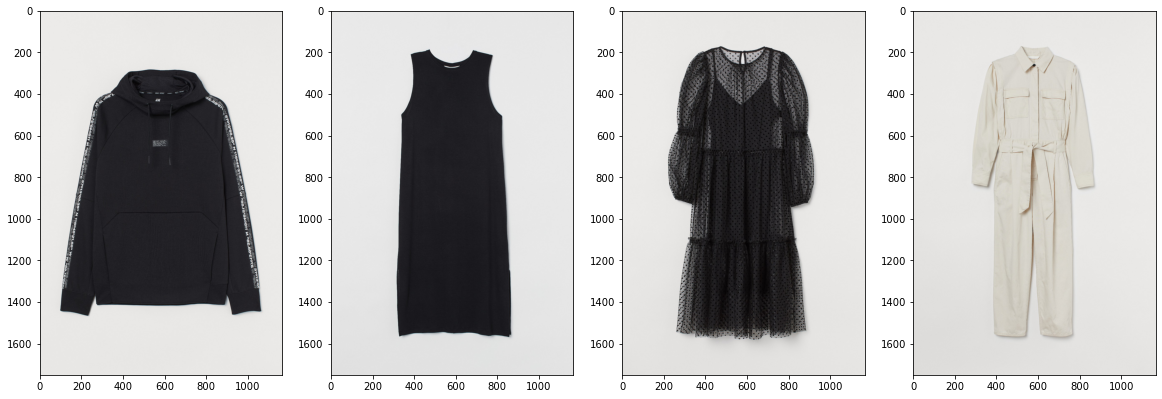

In [41]:
plot_purchase_history()

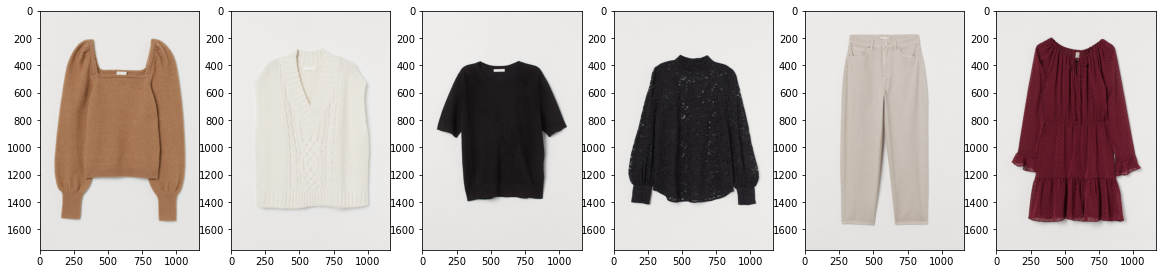

In [42]:
plot_recommendation()